In [69]:
import pandas as pd 
import numpy as np 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller

In [4]:
df = pd.read_csv('p2.csv').rename({'Unnamed: 0': 'Date'}, axis=1)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df

,Y,X1,X2,X3
Date,,,,
2003-03-31,0.000256,0.011485,0.005532,0.0001
2003-06-30,0.006320,-0.004360,0.008566,-0.0003
2003-09-30,-0.009753,0.010864,0.016840,-0.0021
2003-12-31,-0.009998,0.002159,0.011416,-0.0003
2004-03-31,0.007462,0.008588,0.005323,0.0002
...,...,...,...,...
2019-06-30,0.011228,0.005131,0.003700,-0.0003
2019-09-30,0.007050,0.004652,0.006349,-0.0034
2019-12-31,-0.005108,0.007188,0.005845,-0.0049


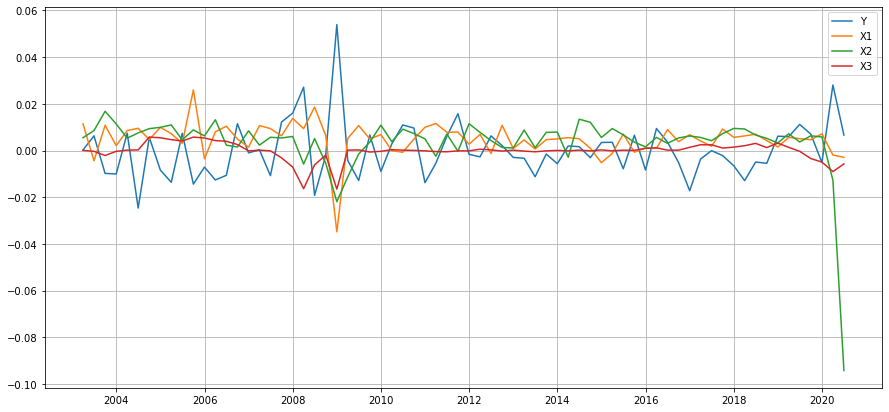

In [18]:
def plot_data(df):
    plt.figure(figsize=(15,7))
    plt.plot(df['Y'], label='Y')
    plt.plot(df['X1'], label='X1')
    plt.plot(df['X2'], label='X2')
    plt.plot(df['X3'], label='X3')
    plt.legend()
    plt.grid()
plot_data(df)

### Clean data 

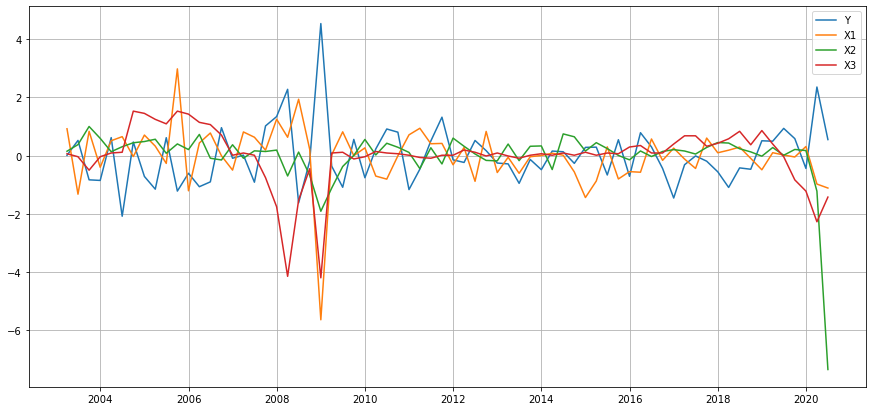

In [21]:
# Normalise 
mean, std = df.mean(), df.std()
df_n = (df - mean) / std
plot_data(df_n)

In [130]:
# Stantionary test 
def stationary_test(val):
    result = adfuller(val)
    if result[0] < result[4]["5%"]: # 5% 
        print('Reject H0 - Time series is Stationary')
    else: 
        print('Failed to reject H0 - Time series is Non-Stationary')

print(stationary_test(df['Y']), stationary_test(df['X1']), stationary_test(df['X2']), stationary_test(df['X3']))

Reject H0 - Time series is Stationary
Reject H0 - Time series is Stationary
Failed to reject H0 - Time series is Non-Stationary
Reject H0 - Time series is Stationary
None None None None


### x2 tests non-stationay mostly due to 2020-march shock 

### Check PACF plot

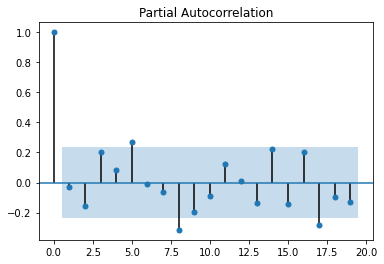

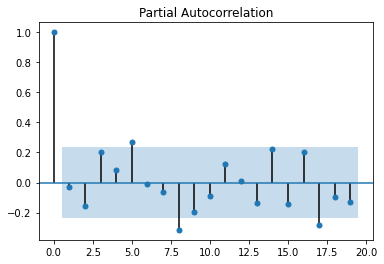

In [131]:
plot_pacf(df['Y'])

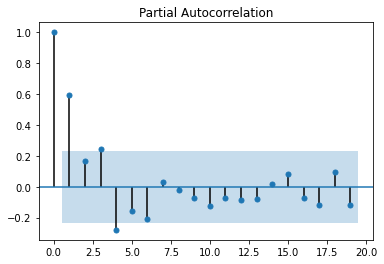

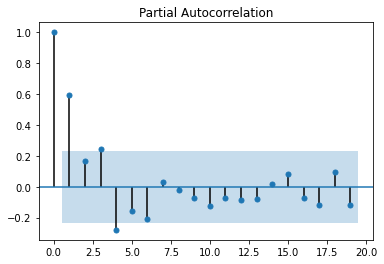

In [132]:
plot_pacf(df['X3'])

### Test possible lags for Xs

In [133]:
%%time
model = VAR(df)
model_fit = model.fit(maxlags=12) # consider 3 years 

CPU times: user 5.68 ms, sys: 1.58 ms, total: 7.26 ms
Wall time: 6.06 ms


In [134]:
model_fit.summary() # only need to look at first table as we only want Y 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Jan, 2021
Time:                     01:21:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -34.8567
Nobs:                     58.0000    HQIC:                  -39.1074
Log likelihood:           1079.57    FPE:                1.59708e-17
AIC:                     -41.8196    Det(Omega_mle):     1.37881e-18
--------------------------------------------------------------------
Results for equation Y
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.011219         0.012784            0.878           0.380
L1.Y           0.385659         0.381492            1.011           0.312
L1.X1          0.104564         0.421340            0.248           0.804
L1.X2         -0.1

#### Final model

after checking p-values under 0.05: 

$$Y_t = 2.654 \times X3_{t-1} +  0.94 \times Y_{t-2} - 4.38 \times X3_{t-3} + 2.72 \times X3_{t-8}$$

In order to predict the next 4 values, we also need X3

$$X3_t = -2.7 \times Y_{t-1} + 0.947 \times X3_{t-3} - 0.735 \times X3_{t-12}$$

In [138]:
df_predict = pd.DataFrame()
df_predict['Y'] = df['Y']
df_predict['X3'] = df['X3']
df_predict

,Y,X3
Date,,
2003-03-31,0.000256,0.0001
2003-06-30,0.006320,-0.0003
2003-09-30,-0.009753,-0.0021
2003-12-31,-0.009998,-0.0003
2004-03-31,0.007462,0.0002
...,...,...
2019-06-30,0.011228,-0.0003
2019-09-30,0.007050,-0.0034
2019-12-31,-0.005108,-0.0049


In [163]:
Y = list(df['Y'].values)
X3 = list(df['X3'].values)
for i in range(4): 
    Y.append(2.654 * X3[-1] + 0.94*Y[-2] - 4.38*X3[-3] + 2.72*X3[-8])
    X3.append(-2.7*Y[-1] + 0.947*X3[-3] -0.735 * X3[-12] )

### The next four steps predictions for Y from VAR model is below

In [167]:
Y[-4:]

[0.036280672179999994,
 -0.22005691852744397,
 1.6142156216331582,
 -11.340317307314006]

### Comment:
#### The result of started diverging from the 3rd prediction. Hence I would not be confident to use the VAR model for more than 2 step prediction. The reason here most likely is, March 2020 brings a much larger Y value, resulting the iteration to explode after 2 iterations.  